In [112]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
import gzip
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from preprocessing import pre_process_df
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
color = sns.color_palette()
%matplotlib inline

In [2]:
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

## Exploración

In [3]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
print("Columnas ", train.shape[1])
print("Filas ", train.shape[0])

Columnas  42
Filas  25192


In [5]:
train.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [6]:
profile = ProfileReport(train, title="Reporte IDS")

In [94]:
profile.to_file("train_ids.html")

## Pre procesamiento

#### Botar constantes
Los valores constantes o con un porcentaje de valores diferentes muy bajos se botaran

In [7]:
constants_c = ["su_attempted", "root_shell", "num_root", "num_file_creations", "num_shells",
              "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "duration", "land",
            "wrong_fragment", "urgent", "hot", "num_failed_logins", "num_compromised"
              ]
train = train.drop(constants_c, axis=1)

In [8]:
train.skew()

/var/folders/r4/363xgjwj3vl40jx0mslxwh_m0000gn/T/ipykernel_26283/3574648760.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.skew()


src_bytes                      157.558542
dst_bytes                       54.777576
logged_in                        0.430597
count                            1.503733
srv_count                        4.707523
serror_rate                      0.952647
srv_serror_rate                  0.963500
rerror_rate                      2.346358
srv_rerror_rate                  2.340787
same_srv_rate                   -0.570489
diff_srv_rate                    4.417749
srv_diff_host_rate               2.885942
dst_host_count                  -0.843161
dst_host_srv_count               0.294306
dst_host_same_srv_rate          -0.004024
dst_host_diff_srv_rate           3.616185
dst_host_same_src_port_rate      2.098527
dst_host_srv_diff_host_rate      5.617065
dst_host_serror_rate             0.958147
dst_host_srv_serror_rate         0.984339
dst_host_rerror_rate             2.363707
dst_host_srv_rerror_rate         2.360484
dtype: float64

## Skew
Ahora se corregira las variables con alto valor de skew

In [9]:
train["src_bytes"] = np.sqrt(train["src_bytes"])

In [10]:
# Ah mejorado pero no completamente
train["src_bytes"].skew()

83.39472752313618

In [11]:
train["src_bytes"] = train["src_bytes"].apply(lambda x: x if x == 0 else np.log(x))

In [12]:
train["src_bytes"].skew()

0.3169739953369961

In [13]:
train["dst_bytes"].unique()

array([   0, 8153,  420, ..., 6160,   99, 2257])

In [14]:
train["dst_bytes"] = train["dst_bytes"].apply(lambda x: x if x == 0 else np.log(x))

In [15]:
train["dst_bytes"].skew()

0.49553932314625837

### Correlación

In [16]:
train.corr()

,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
src_bytes,1.000000,0.703735,0.760517,-0.470088,0.154873,-0.658754,-0.656740,-0.374230,-0.367300,0.758306,...,-0.363332,0.601665,0.640905,-0.230043,0.089142,-0.025026,-0.651566,-0.656090,-0.357692,-0.362869
dst_bytes,0.703735,1.000000,0.816842,-0.500051,-0.050491,-0.530958,-0.527717,-0.300663,-0.294271,0.639030,...,-0.320754,0.736278,0.695825,-0.249593,-0.213261,-0.082407,-0.532389,-0.530703,-0.300434,-0.284881
logged_in,0.760517,0.816842,1.000000,-0.539870,-0.198765,-0.491999,-0.490154,-0.284245,-0.279543,0.600093,...,-0.395905,0.624839,0.607379,-0.255820,-0.159278,-0.057390,-0.490450,-0.492446,-0.274430,-0.270507
count,-0.470088,-0.500051,-0.539870,1.000000,0.469728,0.462505,0.455964,0.159295,0.160807,-0.631890,...,0.466144,-0.399974,-0.477335,0.162274,-0.144247,-0.205608,0.464305,0.464837,0.176579,0.166997
srv_count,0.154873,-0.050491,-0.198765,0.469728,1.000000,-0.148388,-0.147190,-0.112631,-0.113174,0.190199,...,0.146949,0.196931,0.177955,-0.106196,0.151041,-0.058855,-0.145494,-0.145077,-0.099661,-0.111955
serror_rate,-0.658754,-0.530958,-0.491999,0.462505,-0.148388,1.000000,0.993290,-0.227522,-0.227618,-0.764557,...,0.394674,-0.558263,-0.624519,-0.019128,-0.277873,-0.172512,0.978022,0.979602,-0.230977,-0.226133
srv_serror_rate,-0.656740,-0.527717,-0.490154,0.455964,-0.147190,0.993290,1.000000,-0.229120,-0.234571,-0.759104,...,0.392535,-0.555381,-0.620635,-0.032198,-0.277204,-0.170884,0.976363,0.984621,-0.235095,-0.232318
rerror_rate,-0.374230,-0.300663,-0.284245,0.159295,-0.112631,-0.227522,-0.229120,1.000000,0.989134,-0.207791,...,0.071321,-0.251030,-0.259312,0.379101,0.037900,0.029341,-0.226725,-0.226553,0.928992,0.964886
srv_rerror_rate,-0.367300,-0.294271,-0.279543,0.160807,-0.113174,-0.227618,-0.234571,0.989134,1.000000,-0.207949,...,0.074382,-0.249378,-0.257157,0.383078,0.034445,0.026160,-0.227345,-0.231331,0.919537,0.969841
same_srv_rate,0.758306,0.639030,0.600093,-0.631890,0.190199,-0.764557,-0.759104,-0.207791,-0.207949,1.000000,...,-0.508209,0.702810,0.787433,-0.163693,0.279723,0.215362,-0.763522,-0.767487,-0.211556,-0.213591


In [17]:
hightCorrPairs = []
for column in train.columns:
    for column2 in train.columns:
        if column != column2:
            try:                
                corr = abs(train[column].corr(train[column2]))
                if corr >= 0.85:
                    print("La columna ", column, " tiene correlación con ", column2, " con un valor de: ", corr)
                    hightCorrPairs.append(column)
            except: 
                lol = ""

La columna  serror_rate  tiene correlación con  srv_serror_rate  con un valor de:  0.9932900594145543
La columna  serror_rate  tiene correlación con  dst_host_serror_rate  con un valor de:  0.9780218380928436
La columna  serror_rate  tiene correlación con  dst_host_srv_serror_rate  con un valor de:  0.9796019499175194
La columna  srv_serror_rate  tiene correlación con  serror_rate  con un valor de:  0.9932900594145543
La columna  srv_serror_rate  tiene correlación con  dst_host_serror_rate  con un valor de:  0.9763633089084974
La columna  srv_serror_rate  tiene correlación con  dst_host_srv_serror_rate  con un valor de:  0.9846211977176997
La columna  rerror_rate  tiene correlación con  srv_rerror_rate  con un valor de:  0.9891336910126385
La columna  rerror_rate  tiene correlación con  dst_host_rerror_rate  con un valor de:  0.9289919679467995
La columna  rerror_rate  tiene correlación con  dst_host_srv_rerror_rate  con un valor de:  0.9648860357903417
La columna  srv_rerror_rate  tie

In [18]:
# Botar las columnas que no nos son útiles
train = train.drop(
[
    "srv_serror_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "dst_host_same_srv_rate"
],
    axis=1
)

In [19]:
train.corr()

,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate
src_bytes,1.000000,0.703735,0.760517,-0.470088,0.154873,-0.658754,-0.374230,0.758306,-0.213373,0.164840,-0.363332,0.601665,-0.230043,0.089142,-0.025026
dst_bytes,0.703735,1.000000,0.816842,-0.500051,-0.050491,-0.530958,-0.300663,0.639030,-0.219976,0.097872,-0.320754,0.736278,-0.249593,-0.213261,-0.082407
logged_in,0.760517,0.816842,1.000000,-0.539870,-0.198765,-0.491999,-0.284245,0.600093,-0.220632,0.131740,-0.395905,0.624839,-0.255820,-0.159278,-0.057390
count,-0.470088,-0.500051,-0.539870,1.000000,0.469728,0.462505,0.159295,-0.631890,0.218920,-0.263691,0.466144,-0.399974,0.162274,-0.144247,-0.205608
srv_count,0.154873,-0.050491,-0.198765,0.469728,1.000000,-0.148388,-0.112631,0.190199,-0.108290,-0.076921,0.146949,0.196931,-0.106196,0.151041,-0.058855
serror_rate,-0.658754,-0.530958,-0.491999,0.462505,-0.148388,1.000000,-0.227522,-0.764557,0.052455,-0.224884,0.394674,-0.558263,-0.019128,-0.277873,-0.172512
rerror_rate,-0.374230,-0.300663,-0.284245,0.159295,-0.112631,-0.227522,1.000000,-0.207791,0.258269,-0.078896,0.071321,-0.251030,0.379101,0.037900,0.029341
same_srv_rate,0.758306,0.639030,0.600093,-0.631890,0.190199,-0.764557,-0.207791,1.000000,-0.372896,0.277797,-0.508209,0.702810,-0.163693,0.279723,0.215362
diff_srv_rate,-0.213373,-0.219976,-0.220632,0.218920,-0.108290,0.052455,0.258269,-0.372896,1.000000,-0.105626,0.189046,-0.295846,0.493426,-0.006978,-0.086257
srv_diff_host_rate,0.164840,0.097872,0.131740,-0.263691,-0.076921,-0.224884,-0.078896,0.277797,-0.105626,1.000000,-0.352286,0.162177,-0.119897,0.244097,0.379232


Notamos que no tenemos ya valores de correlación absoluta >= a 85 entre columnas

In [20]:
train.head()

,protocol_type,service,flag,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,class
0,tcp,ftp_data,SF,3.098222,0.000000,0,2,2,0.0,0.0,1.00,0.00,0.00,150,25,0.03,0.17,0.00,normal
1,udp,other,SF,2.491803,0.000000,0,13,1,0.0,0.0,0.08,0.15,0.00,255,1,0.60,0.88,0.00,normal
2,tcp,private,S0,0.000000,0.000000,0,123,6,1.0,0.0,0.05,0.07,0.00,255,26,0.05,0.00,0.00,anomaly
3,tcp,http,SF,2.723369,9.006141,1,5,5,0.2,0.0,1.00,0.00,0.00,30,255,0.00,0.03,0.04,normal
4,tcp,http,SF,2.646652,6.040255,1,30,32,0.0,0.0,1.00,0.00,0.09,255,255,0.00,0.00,0.00,normal


### Variables categoricas

In [21]:
train["protocol_type"].unique()

array(['tcp', 'udp', 'icmp'], dtype=object)

In [22]:
train["service"].unique()

array(['ftp_data', 'other', 'private', 'http', 'remote_job', 'name',
       'netbios_ns', 'eco_i', 'mtp', 'telnet', 'finger', 'domain_u',
       'supdup', 'uucp_path', 'Z39_50', 'smtp', 'csnet_ns', 'uucp',
       'netbios_dgm', 'urp_i', 'auth', 'domain', 'ftp', 'bgp', 'ldap',
       'ecr_i', 'gopher', 'vmnet', 'systat', 'http_443', 'efs', 'whois',
       'imap4', 'iso_tsap', 'echo', 'klogin', 'link', 'sunrpc', 'login',
       'kshell', 'sql_net', 'time', 'hostnames', 'exec', 'ntp_u',
       'discard', 'nntp', 'courier', 'ctf', 'ssh', 'daytime', 'shell',
       'netstat', 'pop_3', 'nnsp', 'IRC', 'pop_2', 'printer', 'tim_i',
       'pm_dump', 'red_i', 'netbios_ssn', 'rje', 'X11', 'urh_i',
       'http_8001'], dtype=object)

In [23]:
train["flag"].unique()

array(['SF', 'S0', 'REJ', 'RSTR', 'SH', 'RSTO', 'S1', 'RSTOS0', 'S3',
       'S2', 'OTH'], dtype=object)

In [24]:
# Observando los resultados se procedera a crear dummies

In [25]:
train = pd.get_dummies(train, columns = ['protocol_type', "flag", "service"])

In [26]:
train.head()

,src_bytes,dst_bytes,logged_in,count,srv_count,serror_rate,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,...,service_systat,service_telnet,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois
0,3.098222,0.000000,0,2,2,0.0,0.0,1.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
1,2.491803,0.000000,0,13,1,0.0,0.0,0.08,0.15,0.00,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000,0,123,6,1.0,0.0,0.05,0.07,0.00,...,0,0,0,0,0,0,0,0,0,0
3,2.723369,9.006141,1,5,5,0.2,0.0,1.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
4,2.646652,6.040255,1,30,32,0.0,0.0,1.00,0.00,0.09,...,0,0,0,0,0,0,0,0,0,0


Mover nuestra variable de resultado a un valor numerico como flag

In [27]:
train["class"].unique()

array(['normal', 'anomaly'], dtype=object)

In [28]:
map_class = {
    "normal": 0,
    "anomaly": 1
}
train["class"] = train["class"].apply(lambda x: map_class[x])

### Standar scalar

In [29]:
features = list(filter(lambda x: x != "class", train.columns))
features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type_icmp',
 'protocol_type_tcp',
 'protocol_type_udp',
 'flag_OTH',
 'flag_REJ',
 'flag_RSTO',
 'flag_RSTOS0',
 'flag_RSTR',
 'flag_S0',
 'flag_S1',
 'flag_S2',
 'flag_S3',
 'flag_SF',
 'flag_SH',
 'service_IRC',
 'service_X11',
 'service_Z39_50',
 'service_auth',
 'service_bgp',
 'service_courier',
 'service_csnet_ns',
 'service_ctf',
 'service_daytime',
 'service_discard',
 'service_domain',
 'service_domain_u',
 'service_echo',
 'service_eco_i',
 'service_ecr_i',
 'service_efs',
 'service_exec',
 'service_finger',
 'service_ftp',
 'service_ftp_data',
 'service_gopher',
 'service_hostnames',
 'service_http',
 'service_http_443',
 'service_http_8001',
 'service_imap4',
 'service_iso_tsap'

In [107]:
y_train = train.loc[:,['class']]

In [92]:
X_train = train.loc[:,features].values
X = train.drop(['class'], axis=1)

In [93]:
X_train = StandardScaler().fit_transform(X_train)

In [94]:
x_test = pre_process_df(test)
x_test_pca = StandardScaler().fit_transform(x_test)


## PCA

In [95]:
len(train.columns)-1

95

In [96]:
n_components = 94
whiten = False
random_state = 95

pca = PCA(n_components = n_components, whiten=whiten, random_state=random_state)

In [97]:
x_train_pca = pca.fit_transform(X_train)
x_train_pca = pd.DataFrame(data = x_train_pca)

In [98]:
#Varianza original, aun no se ha aplicado la reduccion de dimensionalidad
print("Varianza de los 94 componentes: ", sum(pca.explained_variance_ratio_))

Varianza de los 94 componentes:  1.0000000000000002


In [99]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)
print('Variance Captured by First 94 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:94].sum(axis=1).values)

Variance Captured by First 10 Principal Components:  [0.28380386]
Variance Captured by First 20 Principal Components:  [0.39636915]
Variance Captured by First 50 Principal Components:  [0.71367156]
Variance Captured by First 94 Principal Components:  [1.]


<AxesSubplot:>

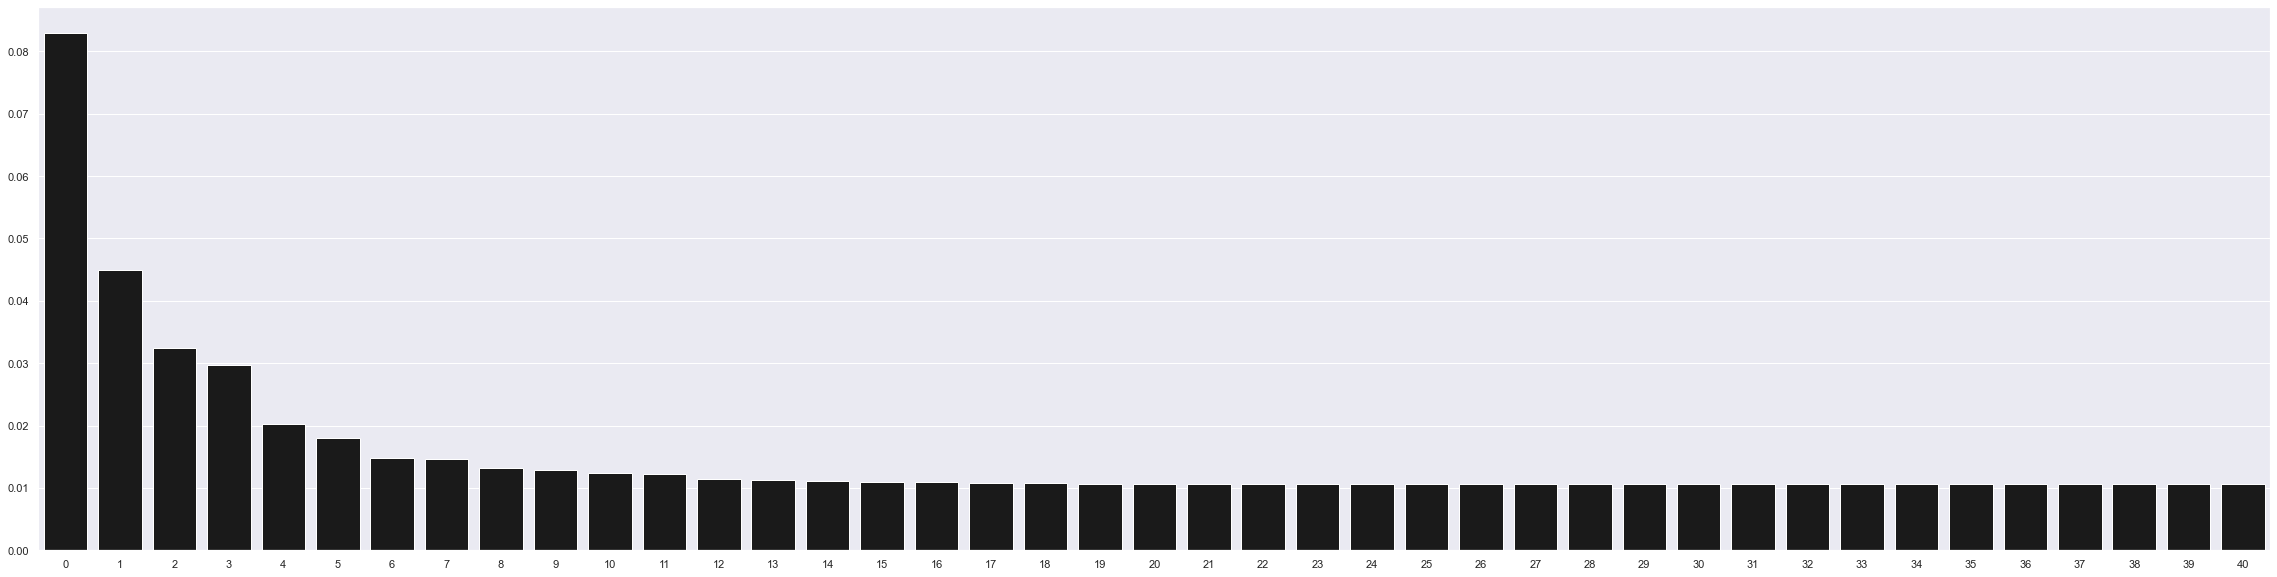

In [100]:
# View percentage captured by first X components
sns.set(rc={'figure.figsize':(40,10)})
sns.barplot(data=importanceOfPrincipalComponents.loc[:,0:40],color='k')

### Proceder a reducir dimensiones


In [101]:
# Calculate reconstruction error
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

# Plot results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [102]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)



In [149]:
n_components = 20
whiten = False
random_state = 20

pca = PCA(n_components = n_components, whiten=whiten, random_state=random_state)

In [150]:
x_train_PCA = pca.fit_transform(X_train)
x_train_PCA = pd.DataFrame(data=x_train_PCA, index=X.index)

In [151]:
x_train_PCA_inverse = pca.inverse_transform(x_train_PCA)
x_train_PCA_inverse = pd.DataFrame(data=x_train_PCA_inverse, \
                                   index=X.index)

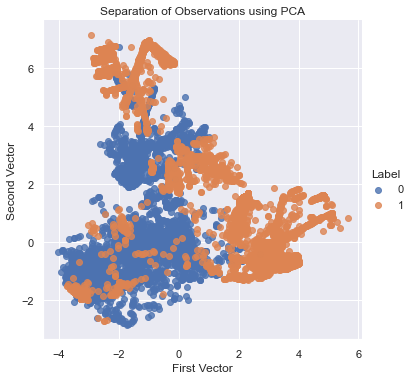

In [152]:
scatterPlot(x_train_PCA, y_train, "PCA")

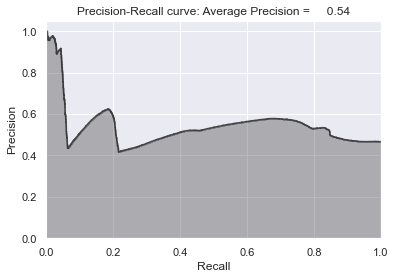

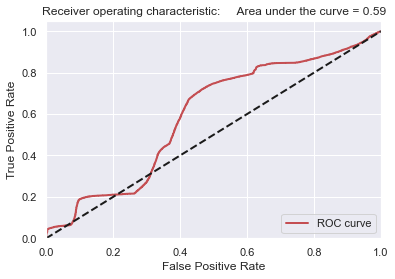

In [153]:
# View plot
anomalyScoresPCA = anomalyScores(X, x_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)